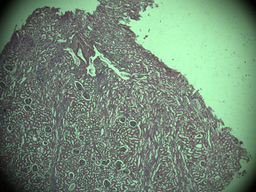

In [1]:
import large_image
source = large_image.open('../tulane_images/libraw_demosaic/20240320022317360.tiff')
source

In [2]:
import numpy as np
width, height, levels = source.sizeX, source.sizeY, source.levels
mask = np.ones((width, height, levels), dtype=np.uint8)

In [3]:
from PIL import Image, ImageDraw
size = (height, width)
mask = Image.new('L', size, 0)
draw = ImageDraw.Draw(mask)

pad = (400, -200)
draw.ellipse((0 - pad[0], 0 - pad[1], size[0] + pad[0], size[1] + pad[1]), fill=255)

mask = np.array(mask)
mask //= 255 # {0, 255} -> {0, 1}
mask = mask.T
mask = np.expand_dims(mask, axis=2)
mask.shape

(4852, 6464, 1)

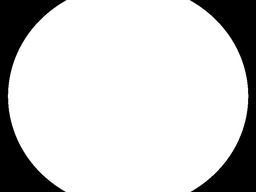

In [4]:
li_mask = large_image.new()
li_mask.addTile(255*mask, 0, 0)
li_mask

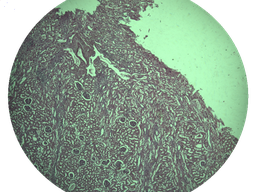

In [5]:
import large_image
new = large_image.new()

for tile in source.tileIterator():
    x, y, w, h = tile['x'], tile['y'], tile['width'], tile['height']

    partial_mask = mask[y:y+h, x:x+w]
    tile = tile['tile']
    tile = np.concatenate((tile, partial_mask * 255), axis=2)

    new.addTile(tile, x, y, mask=partial_mask)

new

In [6]:
# new.write('test.tiff', lossy=False)

In [7]:
with open('../tulane_images/source/AbsolutePixelCoordinate.txt', 'r') as f:
    lines = f.readlines()

items = [x.strip().split(' ') for x in lines]

from ast import literal_eval

items = [(x[0].split('.')[0], literal_eval(x[1])) for x in items]
# items = items[:10]
items

[('20240320022313746', (77.3061, 4.57275)),
 ('20240320022313792', (216.699, 12.2439)),
 ('20240320022313838', (330.135, 20.202)),
 ('20240320022313883', (394.054, 24.3926)),
 ('20240320022313929', (462.174, 28.407)),
 ('20240320022313975', (547.83, 31.726)),
 ('20240320022314021', (665.233, 38.1343)),
 ('20240320022314069', (773.44, 44.4267)),
 ('20240320022314115', (897.807, 52.147)),
 ('20240320022314162', (971.229, 56.373)),
 ('20240320022314209', (1039.02, 60.6848)),
 ('20240320022314259', (1111.38, 63.7957)),
 ('20240320022314307', (1211.33, 70.6626)),
 ('20240320022314347', (1277.75, 74.4168)),
 ('20240320022314393', (1348.3, 78.1238)),
 ('20240320022314437', (1443.17, 83.9902)),
 ('20240320022314486', (1543.79, 90.5208)),
 ('20240320022314530', (1599.42, 94.0162)),
 ('20240320022314575', (1635.74, 96.9619)),
 ('20240320022314620', (1684.32, 99.388)),
 ('20240320022313700', (0, 0)),
 ('20240320022314669', (1756.18, 103.723)),
 ('20240320022314713', (1839.13, 109.265)),
 ('202403

In [8]:
source_list = []
min_y = min([item[1][1] for item in items])
for item in items:
    file_name = f'{item[0]}.tiff'
    source_list.append({
        'path': f'./{file_name}',
        'z': 0,
        'position': {
            'x': round(item[1][0]),
            'y': round(item[1][1] - min_y),
            'scale': 1
        },
        'params': {'style': {'bands': [
            {'palette': '#f00', 'band': 1},
            {'palette': '#0f0', 'band': 2},
            {'palette': '#00f', 'band': 3},
            {
                'palette': ['#fff0', '#ffff'],
                'band': 4,
                'composite': 'multiply'
            }
        ]}}
    })
len(source_list), source_list[:2]

(97,
 [{'path': './20240320022313746.tiff',
   'z': 0,
   'position': {'x': 77, 'y': 4594, 'scale': 1},
   'params': {'style': {'bands': [{'palette': '#f00', 'band': 1},
      {'palette': '#0f0', 'band': 2},
      {'palette': '#00f', 'band': 3},
      {'palette': ['#fff0', '#ffff'], 'band': 4, 'composite': 'multiply'}]}}},
  {'path': './20240320022313792.tiff',
   'z': 0,
   'position': {'x': 217, 'y': 4602, 'scale': 1},
   'params': {'style': {'bands': [{'palette': '#f00', 'band': 1},
      {'palette': '#0f0', 'band': 2},
      {'palette': '#00f', 'band': 3},
      {'palette': ['#fff0', '#ffff'], 'band': 4, 'composite': 'multiply'}]}}}])

In [9]:
import yaml
yaml_str = f'---\n{yaml.dump({"sources": source_list})}'

with open('../tulane_images/masked/composed.yaml', 'w') as f:
    f.write(yaml_str)

In [10]:
mask.shape

(4852, 6464, 1)

In [12]:
import os
os.system('echo $LD_LIBRARY_PATH')

/usr/local/cuda-12/targets/x86_64-linux/lib:


0

In [14]:
import large_image_source_vips

for item in items:
    file_name = f'{item[0]}.tiff'
    source = large_image.open(f'../tulane_images/libraw_demosaic/{file_name}')

    masked = large_image_source_vips.new()

    for tile in source.tileIterator():
        x, y, w, h = tile['x'], tile['y'], tile['width'], tile['height']

        tile_mask = mask[y:y+h, x:x+w]
        tile = tile['tile']
        tile = np.concatenate((tile, tile_mask * 255), axis=2)

        masked.addTile(tile, x, y, mask=tile_mask)

    masked.write(f'../tulane_images/masked/{file_name}', lossy=False)
